In [128]:
import glob
import importlib
import numpy as np
import pandas as pd
import plotting as p
import matplotlib.pyplot as plt
importlib.reload(p)
from sklearn.preprocessing import MinMaxScaler
# plt.style.use("seaborn")

## Leitura e descrição dos dados

In [2]:
A = pd.read_csv("datasets/A.csv", parse_dates=[0])
B = pd.read_csv("datasets/B.csv", parse_dates=[0])
C = pd.read_csv("datasets/C.csv", parse_dates=[0])

In [6]:
(C.shape[0]-3)/96

82.0

In [16]:
C.head()

,TimestampLocal,Watts
0,2012-04-15 00:00:00,463.301114
1,2012-04-15 00:15:00,463.859399
2,2012-04-15 00:30:00,509.015924
3,2012-04-15 00:45:00,523.291556
4,2012-04-15 01:00:00,371.281313


In [17]:
pd.concat([B, C])

,TimestampLocal,Watts
0,2012-04-15 00:00:00,198.028699
1,2012-04-15 00:15:00,170.437709
2,2012-04-15 00:30:00,293.387430
3,2012-04-15 00:45:00,272.922778
4,2012-04-15 01:00:00,167.167000
...,...,...
7870,2012-07-05 23:30:00,725.739019
7871,2012-07-05 23:45:00,688.356507
7872,2012-07-06 00:00:00,757.175667
7873,2012-07-06 00:15:00,625.924583


In [30]:
def input_dados(dados, col, td):
    data_i = dados[col].iloc[0]
    data_f = dados[col].iloc[-1]
    datas = []
    watts = []
    while(data_i<=data_f):
        datas.append(data_i)
        dados[dados[col]==data_i]
        watt = dados[dados[col]==data_i]['Watts'].values[0]
        if np.isnan(watt):
            watt = 0
        watts.append(watt)
        data_i+=td
    return datas, watts

In [8]:
A = A.iloc[:-1]

In [35]:
def add_valores(df, col, n):
    novos_valores = df['Watts'].sample(n).values
    data_final = df[col].iloc[-1]
    td = p.datetime.timedelta(minutes=15)
    novas_datas = []
    for i in range(n):
        data_final+=td
        novas_datas.append(data_final)

    dict_df = {
        col: novas_datas,
        'Watts':novos_valores,
    }
    novo = pd.DataFrame(dict_df)
    novodf = pd.concat([df, novo])
    return novodf

def separar_dias(df, dfname='A', wk=0):
    lista_datas = None
    if dfname=='A':
        df['wk'] = df.apply(lambda r: r.TimestampUTC.weekday(), axis=1)
        lista_datas = df[df['wk']==wk]['TimestampUTC'].values
    else:
        df['wk'] = df.apply(lambda r: r.TimestampLocal.weekday(), axis=1)
        lista_datas = df[df['wk']==wk]['TimestampLocal'].values
    return df[df['wk']==wk]['Watts'].values, lista_datas

def unir_dias(casa,):
    """
    Une partes separadas de um dataset (Seg, Ter, ..., Dom.) em um único dataset
    Algoritmo
    - Definir qual dataset vai ser utilizado ok
    - Carregar dataset ok
    - Fit scaler no dataset original (Seperado) ok
    - Transformar dataset correspondente falso
    - Pegar lista de datas do dataset original (Separado)
    - Concatenar os datasets separados
    - Ordenar os datsets pela data
    - Salvar    
    """
    dfcasa = pd.read_csv(f"datasets/{casa}.csv", parse_dates=[0])   
    dict_casas = {}
    dict_casas_fakes = {}
    dias = ['seg', 'ter', 'qua', 'qui', 'sex', 'sab', 'dom']
    pathfake = f"datasets/generated/separados/{casa}/"
    dfs = []
    for i, d in enumerate(dias):
        watts_dia, datas_dia = separar_dias(dfcasa, dfname=casa, wk=i)
        scaler_dia = MinMaxScaler().fit(watts_dia.reshape(-1,1))
        dict_casas.setdefault(d, {"watts":[], "datas":[]})
        dict_casas_fakes.setdefault(d, [])
        dict_casas[d]["watts"] = watts_dia
        dict_casas[d]["datas"] = datas_dia
        # arquivos do dia d falso
        arquivos_fakes = glob.glob(pathfake+f"{casa}_{d}/*.npy")
        for a in arquivos_fakes:                        
            watts_fake = np.load(a)
            watts_fake = scaler_dia.inverse_transform(watts_fake.reshape(-1,1))
            watts_fake = watts_fake.flatten()[:len(datas_dia)]
            dict_casas_fakes[d].append(watts_fake)

    # gera o numero de datasets salvos por cada
    for i in range(len(dict_casas_fakes['seg'])):
        df = pd.DataFrame()
        for j, d in enumerate(dias):
            watts_fake = dict_casas_fakes[d][i]
            datas_dia = dict_casas[d]["datas"]
            dict_df = {
                "watts": watts_fake,
                "data": datas_dia
            }
            df_fake = pd.DataFrame(dict_df)
            df = pd.concat([df, df_fake])
        
        df.to_csv(f"datasets/generated/separados/{casa}/unidos/{casa}_{i}.csv", index=False)
        dfs.append(df)                
    return dfs

In [34]:
# A
df_fake_dias = unir_dias("A")

<AxesSubplot:>

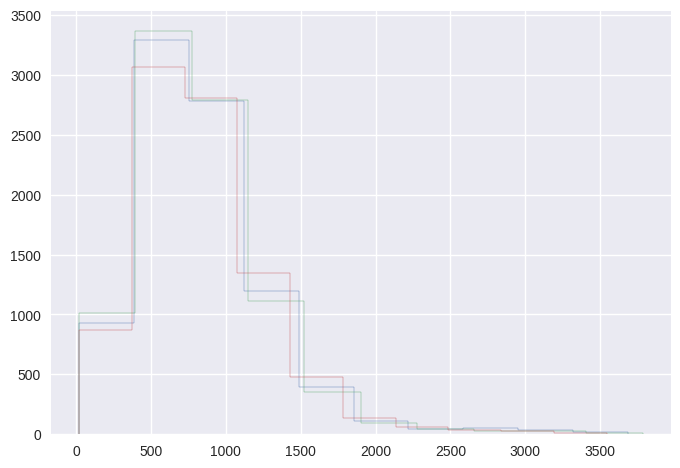

In [32]:
df_fake_dias[0]["watts"].hist(histtype='step')
df_fake_dias[1]["watts"].hist(histtype='step')
df_fake_dias[2]["watts"].hist(histtype='step')

<AxesSubplot:>

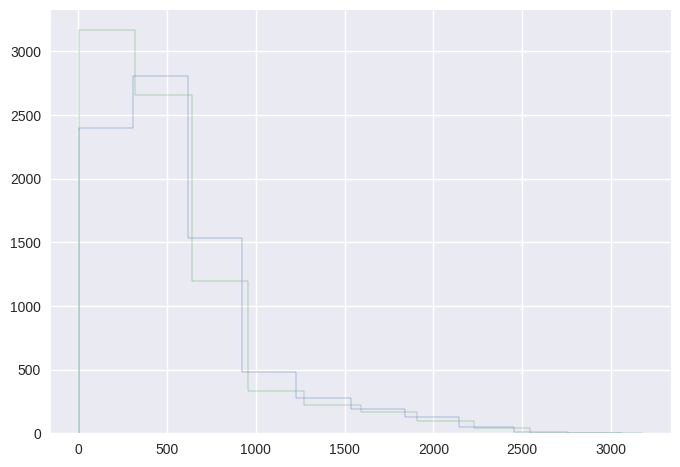

In [38]:
# B
df_fake_dias = unir_dias("B")
df_fake_dias[0]["watts"].hist(histtype='step')
df_fake_dias[1]["watts"].hist(histtype='step');

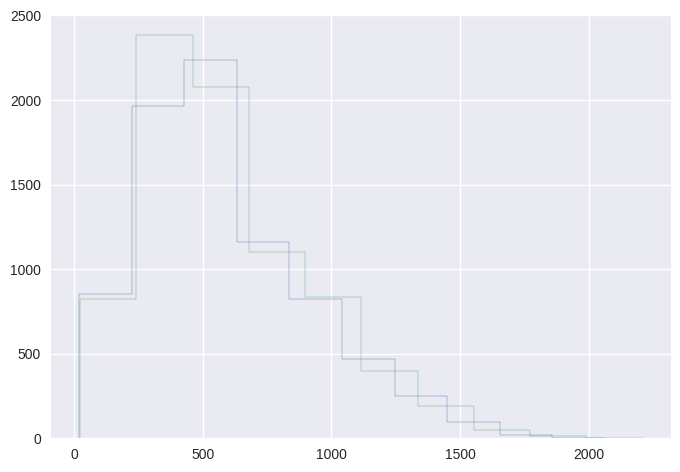

In [39]:
# C
df_fake_dias = unir_dias("C")
df_fake_dias[0]["watts"].hist(histtype='step')
df_fake_dias[1]["watts"].hist(histtype='step');

In [79]:
# A_seg, lista_datas_A_seg = separar_dias(A, dfname='A', wk=0)
# A_ter, lista_datas_A_sab = separar_dias(A, dfname='A', wk=1)
# A_qua, lista_datas_A_seg = separar_dias(A, dfname='A', wk=2)
# A_qui, lista_datas_A_sab = separar_dias(A, dfname='A', wk=3)
# A_sex, lista_datas_A_seg = separar_dias(A, dfname='A', wk=4)
# A_sab, lista_datas_A_sab = separar_dias(A, dfname='A', wk=5)
# A_dom, lista_datas_A_sab = separar_dias(A, dfname='A', wk=6)


Cs = [separar_dias(C, dfname='C', wk=i)[0] for i in range(7)]

In [80]:
for i in range(7):
    print (i, Cs[i].shape[0]/96)

0 12.0
1 12.0
2 12.0
3 12.0
4 11.03125
5 11.0
6 12.0


In [81]:
for i in range(0, 100):
    if  (Cs[4].shape[0] + i)%96== 0:
        print (i)
        break

93


In [77]:
novos_dias = np.random.choice(Bs[4], size=93)
Bs[4] = np.concatenate([Bs[4], novos_dias])

In [68]:
nomes_semanas = ['seg', 'ter', 'qua', 'qui', 'sex', 'sab', 'dom']

In [11]:
len(np.load("datasets/Separados/A/A_seg.npy"))

1344

In [78]:
for n, a in zip(nomes_semanas, Bs):
    np.save("datasets/Separados/B/B_{}.npy".format(n), a)

In [6]:
datas, watts = input_dados(C, 'TimestampLocal', p.datetime.timedelta(minutes=15))

In [26]:
A['Watts'].sample(2).values

array(['504.5041734693878', '532.9199733893557'], dtype=object)

In [7]:
dict_novoC = {
    'TimestampLocal':datas,
    'Watts':watts
}
novoC = pd.DataFrame(dict_novoC)

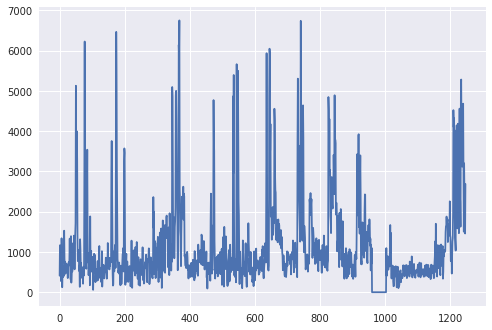

In [69]:
plt.plot(As[5])

In [68]:
novoA.to_csv('datasets/A.csv', index=False)
novoB.to_csv('datasets/B.csv', index=False)
novoC.to_csv('datasets/C.csv', index=False)

In [85]:
lista_datas = A['TimestampUTC'].values

In [20]:
bikes['cnt'].describe()

count    78888.000000
mean       329.480884
std        337.722508
min          0.000000
25%         59.000000
50%        226.000000
75%        487.000000
max       2037.000000
Name: cnt, dtype: float64

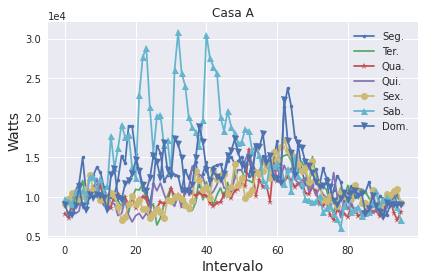

In [94]:
real_data = A[["Watts"]].values.reshape(A.shape[0]//96, 96)
df_real = p.get_df(list_dates=lista_datas, data=A[["Watts"]].values, timesteps=96)
lista_cnt = [p.get_count(df_real,w,96, column="ts")["cnt_0"] for w in range(7)]
p.plot_sum_real(list_cnt_real=lista_cnt, list_dates=lista_datas)
plt.ticklabel_format(style="sci", axis="y", scilimits=(0,0))
plt.ylabel("Watts")
plt.xlabel("Intervalo")
plt.title("Casa A")
plt.tight_layout()

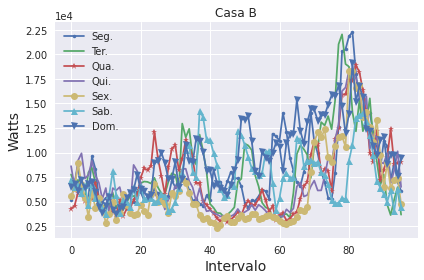

In [95]:
lista_datas_B = B['TimestampLocal'].values
real_data = B[["Watts"]].values.reshape(B.shape[0]//96, 96)
df_real = p.get_df(list_dates=lista_datas_B, data=B[["Watts"]].values, timesteps=96)
lista_cnt = [p.get_count(df_real,w,96, column="ts")["cnt_0"] for w in range(7)]
p.plot_sum_real(list_cnt_real=lista_cnt, list_dates=lista_datas)
plt.ticklabel_format(style="sci", axis="y", scilimits=(0,0))
plt.ylabel("Watts")
plt.xlabel("Intervalo")
plt.title("Casa B")
plt.tight_layout()

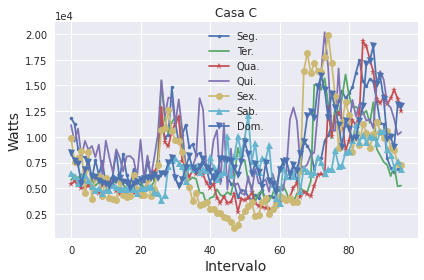

In [96]:
lista_datas_C = C['TimestampLocal'].values
real_data = C[["Watts"]].values.reshape(C.shape[0]//96, 96)
df_real = p.get_df(list_dates=lista_datas_C, data=C[["Watts"]].values, timesteps=96)
lista_cnt = [p.get_count(df_real,w,96, column="ts")["cnt_0"] for w in range(7)]
p.plot_sum_real(list_cnt_real=lista_cnt, list_dates=lista_datas)
plt.ticklabel_format(style="sci", axis="y", scilimits=(0,0))
plt.ylabel("Watts")
plt.xlabel("Intervalo")
plt.title("Casa C")
plt.tight_layout()

## Desafios de modelagem

- TODO: mostrar como sumarização não funciona (gerar dados falsos com a mesma métrica)

In [ ]:
path_lista_fakes = glob.glob('datasets/generated/*.npy')

In [ ]:
import numpy as np

In [ ]:
a = np.load(path_lista_fakes[0])

In [ ]:
dict_weeks = {i:p.get_list_wks(path_lista_fakes, lista_datas, 24, wk=i) for i in range(7)}

In [ ]:
a = np.array(dict_weeks[0][0])

# GAN

In [2]:
A_sab = np.load("datasets/A_sab.npy")

In [4]:
from sklearn.preprocessing import MinMaxScaler
from synthesizers.gan import ModelParameters
from timegan.model import TimeGAN

In [26]:
# Specific to TimeGANs
seq_len=96
n_seq = 1
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 1

log_step = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

In [7]:
#treino = A['Watts'].values
treino = A_sab

In [8]:
scaler = MinMaxScaler().fit(treino.reshape(-1,1))
treino_scaled = scaler.transform(treino.reshape(-1,1))
treino_s = treino_scaled.reshape(len(treino)//96, 96, 1)

In [ ]:
synth = TimeGAN(model_parameters=gan_args, hidden_dim=hidden_dim, seq_len=seq_len, n_seq=n_seq, gamma=gamma)
synth.train(treino_s, train_steps=5000)

In [21]:
synth = TimeGAN.load("modelos/casa_A_sab_bs1.pkl")

In [22]:
for i in range(2):
    synth_data = synth.sample(len(treino_s))
    np.save("datasets/melhorando/A_sab_bs1/timegan_{}.npy".format(i), synth_data)

Synthetic data generation: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


In [15]:
treino_s = MinMaxScaler().fit_transform(treino.reshape(-1,1))
treino_s = treino_s.reshape(treino.shape[0],1)

In [16]:
df_sample = p.get_df(lista_datas[:365*24], treino_s, timesteps=24)
dict_weeks_real = {wk:p.get_count(df_sample,wk,timestep=24, column='ts')['cnt_0'] for wk in range(7)} 

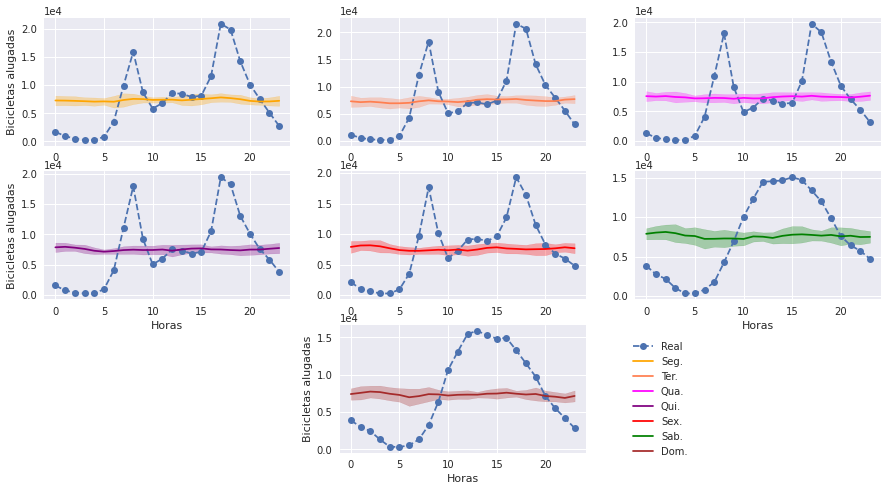

In [11]:
df_sample = p.get_df(lista_datas[:365*24], treino.reshape(-1,1 ), timesteps=24)
dict_weeks_real_arima = {wk:p.get_count(df_sample,wk,timestep=24, column='ts')['cnt_0'] for wk in range(7)} 

path_lista_fakes = glob.glob("datasets/generated/arima2/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas[:365*24], 24, wk=i) for i in range(7)}
# fig, axes = p.plot_compare_sum(dict_weeks_fakes, dict_weeks_real_arima, bbox=(1.45, -0.1), figtitle="".format(o, so), scaler=None)
p.plot_compare_sum(dict_weeks_fakes, dict_weeks_real_arima, bbox=(1.45, -0.1), figtitle="", scaler=None)
plt.savefig("imagens/analises/bike_somas_arima.pdf")

In [24]:
for i, ax2 in enumerate(axes):
    # Save just the portion _inside_ the second axis's boundaries
    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # fig.savefig('ax2_figure.png', bbox_inches=extent)

    # Pad the saved area by 10% in the x-direction and 20% in the y-direction
    fig.savefig('imagens/analises/subfigures/arima_ax{}.pdf'.format(i), bbox_inches=extent.expanded(1.1, 1.2))


# Casa A

In [18]:
A = A
lista_datas_A = A['TimestampUTC'].values

In [20]:
treino = A['Watts'].values
scalerA = MinMaxScaler().fit(treino.reshape(-1,1))
treino_scaled = scalerA.transform(treino.reshape(-1,1))
treino_s = treino_scaled.reshape(len(treino)//96, 96, 1)

In [21]:
df_sample = p.get_df(lista_datas_A, treino_s.reshape(len(treino), 1), timesteps=96)
dict_weeks_real = {wk:p.get_count(df_sample, wk, timestep=96, column='ts')['cnt_0'] for wk in range(7)}

## Melhorando

In [15]:
path_falsos = glob.glob("datasets/melhorando/A_sab_bs4/*.npy")
falsos = [np.load(f) for f in path_falsos]
falsos = [scaler.inverse_transform(f.reshape(-1,1)) for f in falsos]

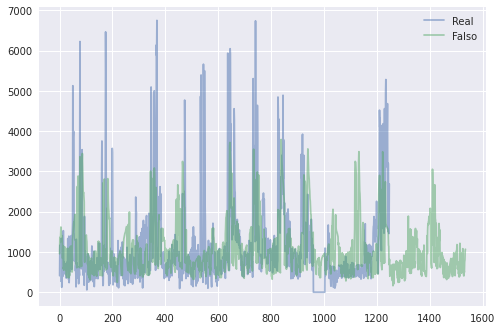

In [20]:
plt.plot(A_sab.flatten(), label='Real', alpha=0.5)
plt.plot(falsos[1].flatten(), label='Falso', alpha=0.5)
plt.legend()

In [23]:
path_falsos = glob.glob("datasets/melhorando/A_sab_bs1/*.npy")
falsos = [np.load(f) for f in path_falsos]
falsos = [scaler.inverse_transform(f.reshape(-1,1)) for f in falsos]

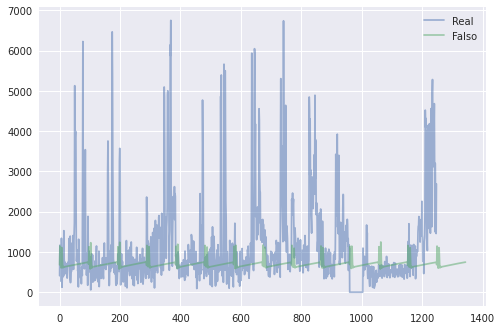

In [25]:
plt.plot(A_sab.flatten(), label='Real', alpha=0.5)
plt.plot(falsos[0].flatten(), label='Falso', alpha=0.5)
plt.legend()

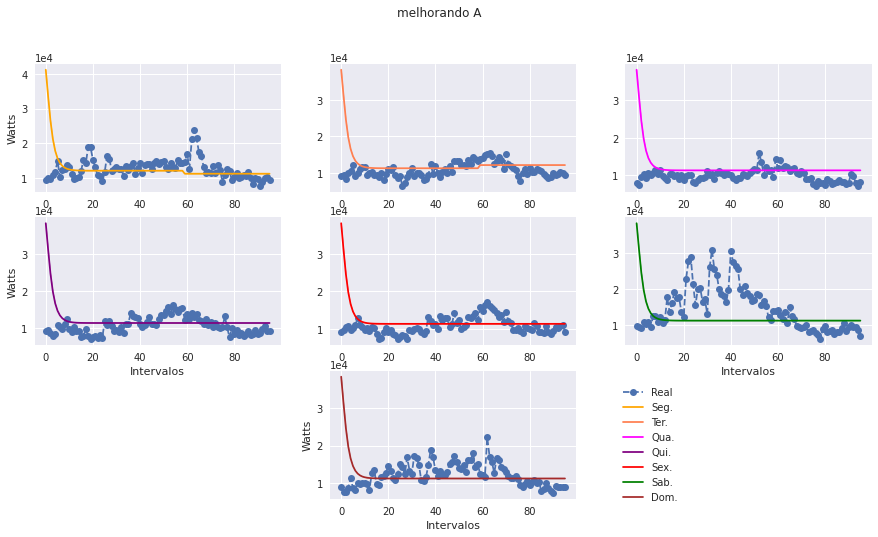

In [22]:
path_lista_fakes = glob.glob("datasets/melhorando/A/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas_A, 96, wk=i) for i in range(7)}
p.plot_compare_sum(dict_weeks_fakes,dict_weeks_real, bbox=(1.45, -0.1), 
    ts=96, figtitle="melhorando A", scaler=scalerA, ylabel='Watts', xlabel='Intervalos');

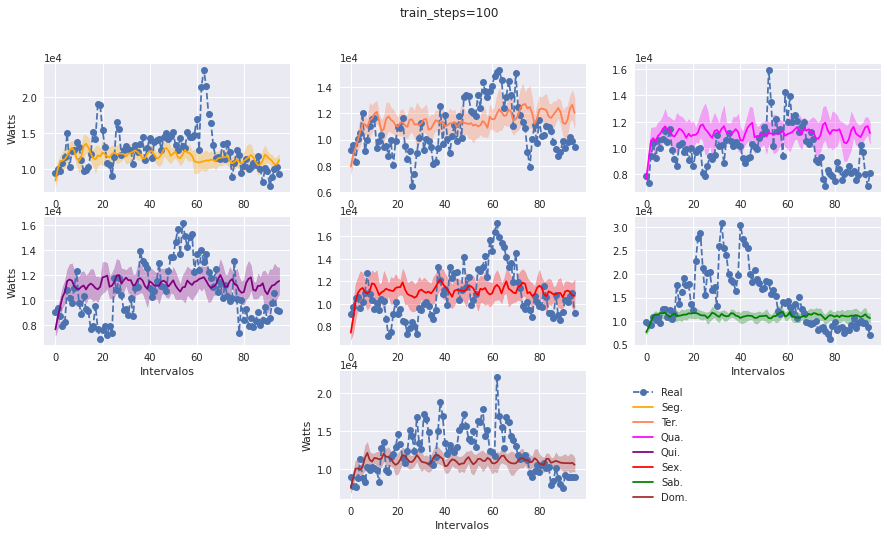

In [8]:
path_lista_fakes = glob.glob("datasets/generated/A/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas_A, 96, wk=i) for i in range(7)}
p.plot_compare_sum(dict_weeks_fakes,dict_weeks_real, bbox=(1.45, -0.1), 
    ts=96, figtitle="train_steps=100", scaler=scalerA, ylabel='Watts', xlabel='Intervalos');

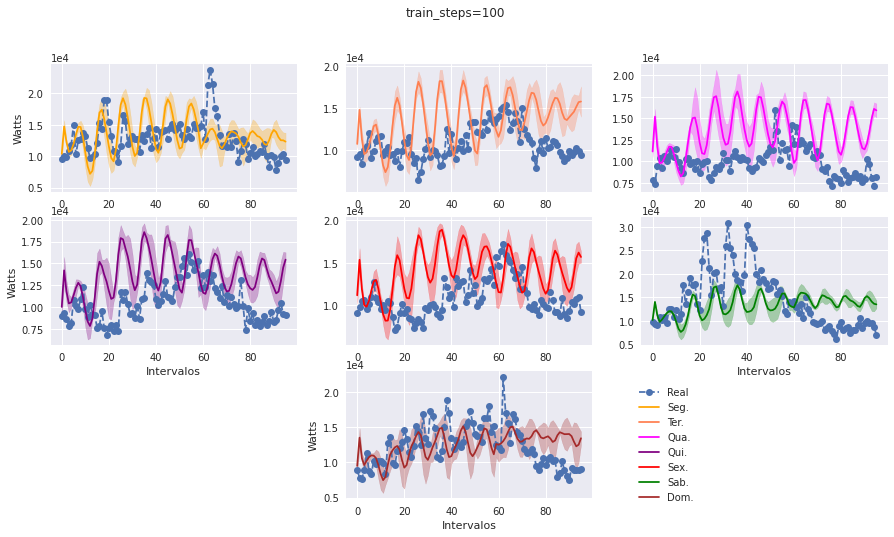

In [9]:
path_lista_fakes = glob.glob("datasets/generated/A1/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas_A, 96, wk=i) for i in range(7)}
p.plot_compare_sum(dict_weeks_fakes,dict_weeks_real, bbox=(1.45, -0.1), 
    ts=96, figtitle="train_steps=100", scaler=scalerA, ylabel='Watts', xlabel='Intervalos');

Modelo_4_bs_28

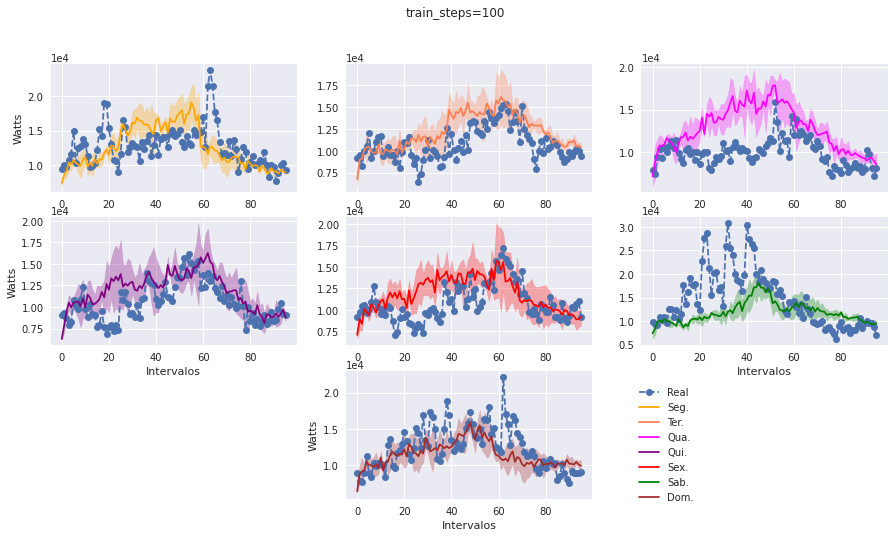

In [10]:
path_lista_fakes = glob.glob("datasets/generated/A2/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas_A, 96, wk=i) for i in range(7)}
p.plot_compare_sum(dict_weeks_fakes,dict_weeks_real, bbox=(1.45, -0.1), 
    ts=96, figtitle="train_steps=100", scaler=scalerA, ylabel='Watts', xlabel='Intervalos');

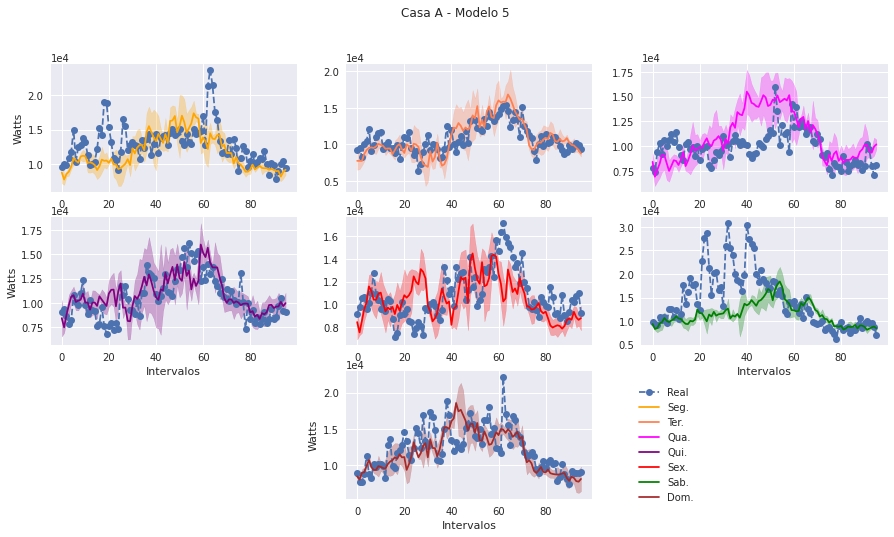

In [13]:
path_lista_fakes = glob.glob("datasets/generated/A3/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas_A, 96, wk=i) for i in range(7)}
p.plot_compare_sum(dict_weeks_fakes,dict_weeks_real, bbox=(1.45, -0.1), 
    ts=96, figtitle="Casa A - Modelo 5", scaler=scalerA, ylabel='Watts', xlabel='Intervalos');

## Semanas

In [123]:
A_sab = np.load("datasets/A_sab.npy")
A_sab = A_sab

In [72]:
lista_sab_A = glob.glob("datasets/generated_semanas/A/*.npy")

In [170]:
# fk1 = np.load(lista_sab_A[1])
fk1 = np.load("datasets/generated_semanas/A/timegan_sab_0.npy")
fk1 = fk1.flatten()

In [174]:
fake_A = np.load("datasets/generated/A3/timegan_0.npy")
fake_A = fake_A.flatten()[:len(lista_datas_A)]

In [196]:
dict_fake={
    'TimestampUTC':lista_datas_A,
    'Watts':fake_A
}
df_fake = pd.DataFrame(dict_fake)

In [197]:
for i in range(len(lista_datas_sab_A)):
    idx = df_fake[df_fake['TimestampUTC']==lista_datas_sab_A[i]].index[0]
    df_fake.loc[idx,'Watts'] = fk1[i]

In [199]:
treino_fake = df_fake['Watts'].values

In [200]:
df_sample_fake = p.get_df(lista_datas_A, treino_fake.reshape(len(treino), 1), timesteps=96)
dict_weeks_fake = {wk:p.get_count(df_sample_fake, wk, timestep=96, column='ts')['cnt_0'] for wk in range(7)}

In [ ]:
0.069565

In [126]:
scaler = MinMaxScaler().fit(A_sab.reshape(-1,1))

In [107]:
df_fk = pd.read_csv("datasets/generated_csvs/A/A_0.csv", parse_dates=[0])

In [65]:
A_sab = A_sab.reshape(len(A_sab)//32, 32)

In [133]:
len_A_sab = len(A_sab)

In [134]:
fk_sab = scaler.inverse_transform(fk1[:len_A_sab].reshape(-1,1))
fk_sab = fk_sab.reshape(13, 96)

In [141]:
A_sab = A_sab.reshape(96,13)

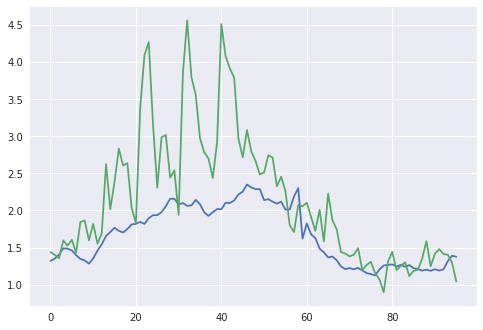

In [203]:
plt.plot(dict_weeks_fake[5])
plt.plot(dict_weeks_real[5])

In [146]:
A_sab.sum(axis=1)

array([ 9046.53122073,  8764.58728914,  9830.84247344, 19140.38882567,
       19736.40139148, 14302.73739537, 20086.08857719,  9915.74501173,
        7128.6599802 ,  7034.29742903,  7504.04735522,  8855.93476824,
       17104.16692009, 26907.47094317,  6793.18621759, 17150.79882381,
        6334.57713661,  9645.65022579,  8124.32792286,  6940.29698373,
        8487.52393571,  8444.934991  , 13379.63429699, 12652.37537533,
       12770.92637329, 17510.87459099, 24044.82243673, 31061.21768716,
       35708.16569753, 19886.59351556,  8324.86584098,  7726.4132339 ,
        8624.15712881, 12330.40872396,  9695.58181596, 12337.57858719,
       19938.9534664 ,  9253.95404121, 10121.78417056,  9725.03465293,
        9105.56355709, 29475.8966504 , 20594.88712257,  8321.68668897,
       11336.79028824,  6558.66286892,  8789.46459917,  9169.0162556 ,
       17123.57603089, 34396.84217973, 29804.98900948, 21980.42434035,
       14478.15295265,  8294.47899078, 10509.35615102, 11955.12341416,
      

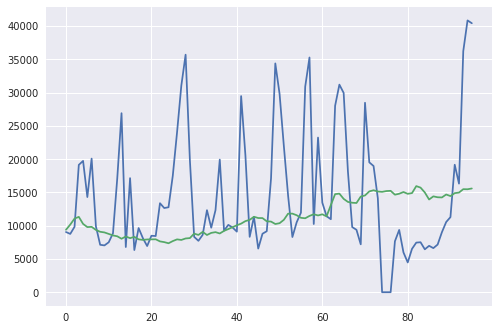

In [142]:
plt.plot(np.sum(A_sab, axis=1))
plt.plot(np.sum(fk_sab, axis=0))


### Casa A segunda

In [8]:
import joblib

In [1]:
from timegan.model import TimeGAN

2023-03-28 13:55:38.782018: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-28 13:55:38.782040: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import numpy as np

In [4]:
def salvar_casa(modelo, path, n=3, n_original=None):
    for i in range(n):
        synth = modelo.sample(n_original)
        np.save(path+"{}".format(i), synth)

In [30]:
casa = "C"
for dia in nomes:
    print ("Carregando modelo para {}".format(dia))
    modelo = TimeGAN.load("modelos/{}/casa_{}_{}_bs4.pkl".format(casa, casa, dia))

    A_dia = np.load("datasets/Separados/{}/{}_{}.npy".format(casa, casa, dia))
    A_dia = A_dia.reshape(len(A_dia)//96, 96, 1)
    print ("Gerando dados")
    salvar_casa(modelo, path="datasets/generated/separados/{}/{}_{}/".format(casa, casa, dia), n=2, n_original=A_dia.shape[0])

Carregando modelo para seg
Gerando dados


Synthetic data generation: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


Carregando modelo para ter
Gerando dados


Synthetic data generation: 100%|██████████| 4/4 [00:02<00:00,  1.33it/s]


Carregando modelo para qua
Gerando dados


Synthetic data generation: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


Carregando modelo para qui
Gerando dados


Synthetic data generation: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


Carregando modelo para sex
Gerando dados


Synthetic data generation: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


Carregando modelo para sab
Gerando dados


Synthetic data generation: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Carregando modelo para dom
Gerando dados


Synthetic data generation: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Synthetic data generation: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


In [23]:
import os

In [27]:
nomes = ["seg", "ter", "qua", "qui", "sex", "sab", "dom"]
casa = "C"
for n in nomes:
    path = "datasets/generated/separados/{}/{}_{}/".format(casa, casa, n)
    os.mkdir(path)

# Casa B

In [13]:
B = B.iloc[:-3]
lista_datas_B = B['TimestampLocal'].values

In [15]:
treino = B['Watts'].values
scalerB = MinMaxScaler().fit(treino.reshape(-1,1))
treino_scaled = scalerB.transform(treino.reshape(-1,1))
treino_s = treino_scaled.reshape(len(treino)//96, 96, 1)

df_sample = p.get_df(lista_datas_B, treino_s.reshape(len(treino), 1), timesteps=96)
dict_weeks_real = {wk:p.get_count(df_sample, wk,timestep=96, column='ts')['cnt_0'] for wk in range(7)}

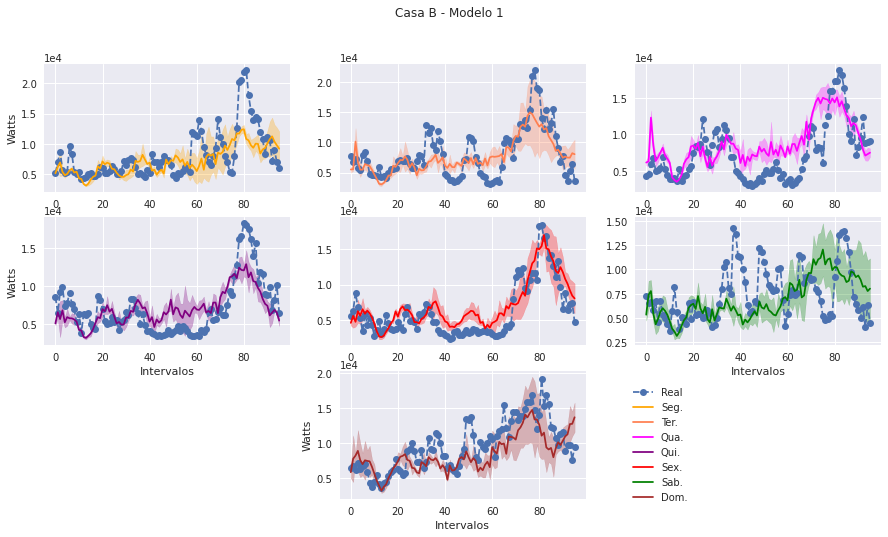

In [17]:
path_lista_fakes = glob.glob("datasets/generated/B/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas_B, 96, wk=i) for i in range(7)}
p.plot_compare_sum(dict_weeks_fakes,dict_weeks_real, bbox=(1.45, -0.1), 
    ts=96, figtitle="Casa B - Modelo 1", scaler=scalerB, ylabel='Watts', xlabel='Intervalos');

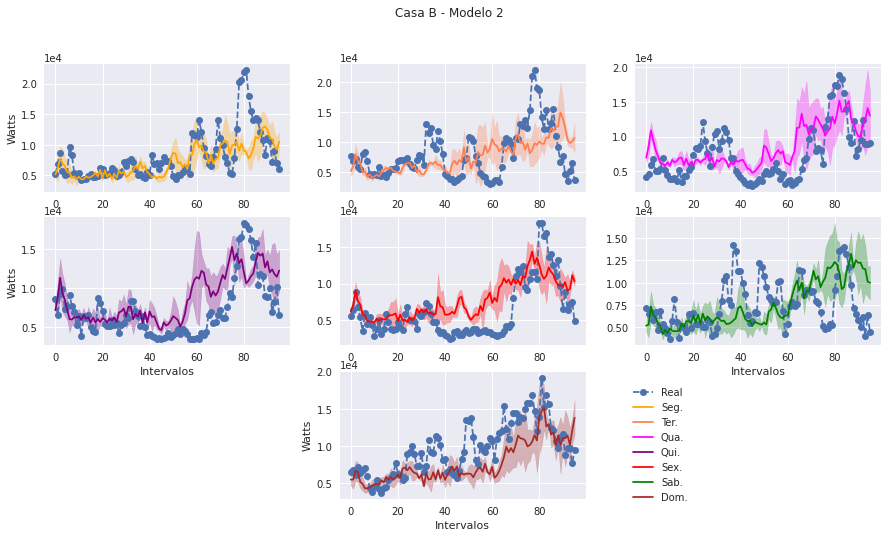

In [19]:
path_lista_fakes = glob.glob("datasets/generated/B1/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas_B, 96, wk=i) for i in range(7)}
p.plot_compare_sum(dict_weeks_fakes,dict_weeks_real, bbox=(1.45, -0.1), 
    ts=96, figtitle="Casa B - Modelo 2", scaler=scalerB, ylabel='Watts', xlabel='Intervalos');

# Casa C

In [134]:
C = C.iloc[:-3]
lista_datas_C = C['TimestampLocal'].values

In [135]:
treino = C['Watts'].values
scalerC = MinMaxScaler().fit(treino.reshape(-1,1))
treino_scaled = scalerC.transform(treino.reshape(-1,1))
treino_s = treino_scaled.reshape(len(treino)//96, 96, 1)

In [136]:
df_sample = p.get_df(lista_datas_C, treino_s.reshape(len(treino), 1), timesteps=96)
dict_weeks_real = {wk:p.get_count(df_sample, wk,timestep=96, column='ts')['cnt_0'] for wk in range(7)}

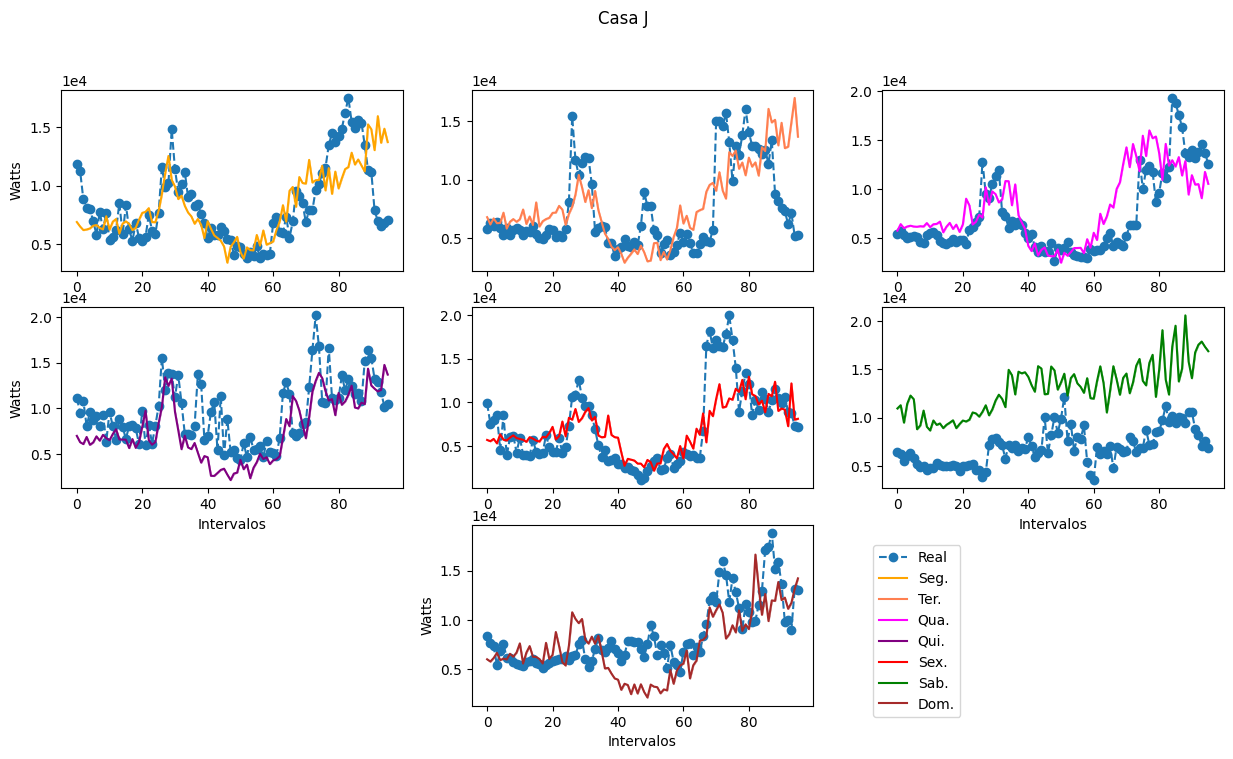

In [139]:
path_lista_fakes = glob.glob("datasets/generated/C/timegan_1.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas_C, 96, wk=i) for i in range(7)}
p.plot_compare_sum(dict_weeks_fakes,dict_weeks_real, bbox=(1.45, -0.1), 
    ts=96, figtitle="Casa J", scaler=scalerB, ylabel='Watts', xlabel='Intervalos');

In [71]:
path_lista_fakes = glob.glob("datasets/generated/C/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas_C, 96, wk=i) for i in range(7)}
p.plot_compare_sum(dict_weeks_fakes,dict_weeks_real, bbox=(1.45, -0.1), 
    ts=96, figtitle="Casa A - Modelos C", scaler=scalerB, ylabel='Watts', xlabel='Intervalos');

ValueError: cannot reshape array of size 7872 into shape (8832,1)

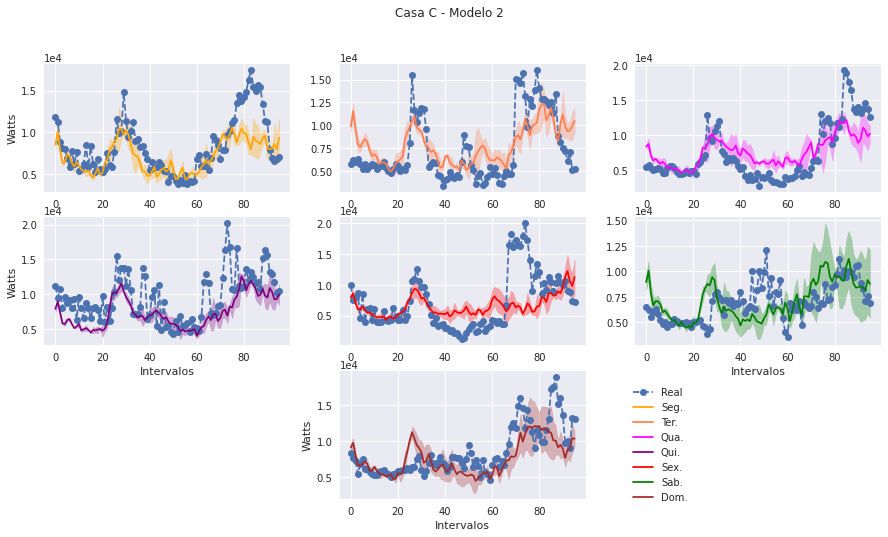

In [25]:
path_lista_fakes = glob.glob("datasets/generated/C1/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas_B, 96, wk=i) for i in range(7)}
p.plot_compare_sum(dict_weeks_fakes,dict_weeks_real, bbox=(1.45, -0.1), 
    ts=96, figtitle="Casa C - Modelo 2", scaler=scalerB, ylabel='Watts', xlabel='Intervalos');

# Experimentos

In [8]:
from sklearn.preprocessing import MinMaxScaler
from synthesizers.gan import ModelParameters
from timegan.model import TimeGAN

2023-04-24 10:29:30.372917: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-24 10:29:30.372952: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Batchsize 28 (1 mês)

In [9]:
casa = "C"
df = pd.read_csv(f"datasets/{casa}.csv", parse_dates=[0])
data = df['Watts'].values
scaler = MinMaxScaler().fit(data.reshape(-1,1))
data = data[:-3]
size_sample = len(data)//96

modelo = TimeGAN.load(f"modelos/bs28/casa_{casa}_bs28.pkl")
datas = df["TimestampLocal"].values
for i in range(3):
    print (f"Dataset {i}")   
    fake_data = modelo.sample(size_sample)
    fake_data = fake_data.flatten()[:len(df)]
    fake_data = scaler.inverse_transform(fake_data.reshape(-1,1))
    dict_fake = {
        'data': datas,
        'Watts': fake_data.flatten()
    }
    df_fake = pd.DataFrame(dict_fake)
    df_fake.to_csv(f"datasets/generated/bs28/{casa}/{casa}_{i}.csv", index=False)

2023-04-24 10:29:46.354921: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-24 10:29:46.354960: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-24 10:29:46.354982: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iranlprm): /proc/driver/nvidia/version does not exist


Dataset 0


Synthetic data generation: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Dataset 1


Synthetic data generation: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Dataset 2


Synthetic data generation: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


# Salvar casas

In [15]:
def salvar_casas(nome='A'):
    df = pd.read_csv("datasets/{}.csv".format(nome), parse_dates=[0])
    coluna_data = 'TimestampLocal'
    if nome=='A':
        coluna_data = 'TimestampUTC'
    lista_datas_df = df[coluna_data].values
    dados_fakes = glob.glob('datasets/generated/{}/*.npy'.format(nome))
    scaler = MinMaxScaler().fit(df['Watts'].values.reshape(-1,1))

    for i, d in enumerate(dados_fakes):
        arr = np.load(d).flatten()
        arr = arr[:len(lista_datas_df)]
        arr = scaler.inverse_transform(arr.reshape(-1,1)).flatten()
        dict_novo = {
            coluna_data:lista_datas_df,
            'Watts':arr
        }
        novodf = pd.DataFrame(dict_novo)
        novodf.to_csv("datasets/generated_csvs/{}/{}_{}.csv".format(nome, nome, i), index=False)

In [16]:
salvar_casas('A')

## Avaliação

In [46]:
import residuals as r
importlib.reload(r)
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [31]:
rnn_model = r.make_rnn_model(units=32, n_layers=2, net_type='lstm')

2022-07-06 10:51:29.282348: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-06 10:51:29.282375: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-06 10:51:29.282399: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iranlprm): /proc/driver/nvidia/version does not exist


In [27]:
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 24, 32)            4352      
                                                                 
 LSTM_2 (LSTM)               (None, 32)                8320      
                                                                 
 OUT (Dense)                 (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [32]:
opt = Adam(learning_rate=5e-4)
rnn_model.compile(optimizer=opt, loss='mse')

In [35]:
X, Y = r.split_sequence(treino_s.flatten(),24)
X = X.reshape(X.shape[0],X.shape[1],1)

In [38]:
early_stop = EarlyStopping(monitor='loss')
hist=rnn_model.fit(X,Y,epochs=50,batch_size=28,callbacks=[early_stop])

Epoch 1/50
312/312 [==============================] - 8s 15ms/step - loss: 0.0317
Epoch 2/50
312/312 [==============================] - 5s 17ms/step - loss: 0.0165


In [39]:
synth_m1 = glob.glob("datasets/generated/timegan/1/*.npy")
synth_m2 = glob.glob("datasets/generated/timegan/2/*.npy")
synth_m3 = glob.glob("datasets/generated/timegan/3/*.npy")

In [40]:
X_pred = rnn_model.predict(X)

273/273 [==============================] - 2s 6ms/step


In [41]:
%%time
reid_m1 = [r.get_residuals(f, X_pred) for f in synth_m1]
reid_m2 = [r.get_residuals(f, X_pred) for f in synth_m2]
reid_m3 = [r.get_residuals(f, X_pred) for f in synth_m3]
resid_arima = res.resid

CPU times: user 1.36 s, sys: 1.38 s, total: 2.74 s
Wall time: 3.1 s


In [42]:
%%time
dict_resid = {
    'mu': [ np.mean(resid_arima),  np.mean(reid_m1), np.mean(reid_m2), np.mean(reid_m3)],
    'std': [np.std(resid_arima), np.std(reid_m1), np.std(reid_m2), np.std(reid_m3)]
}

CPU times: user 10.3 s, sys: 4.59 s, total: 14.9 s
Wall time: 16.1 s


In [43]:
df_resid = pd.DataFrame(dict_resid, index=['arima', 'm1', 'm2', 'm3'])

In [44]:
df_resid

,mu,std
arima,-0.008845,64.608229
m1,0.043540,0.197042
m2,-0.012750,0.247794
m3,-0.048837,0.276025


In [27]:
res.resid.mean()

-0.00884502621089828

In [3]:
d = input("Digite algo", 'int')

TypeError: raw_input() takes from 1 to 2 positional arguments but 3 were given

# C

In [24]:
A = pd.read_csv("datasets/A.csv", parse_dates=[0])
B = pd.read_csv("datasets/B.csv", parse_dates=[0])
C = pd.read_csv("datasets/C.csv", parse_dates=[0])

In [99]:
i = pd.read_csv("datasets/generated_csvs/C/C_0.csv", parse_dates=[0])
j = pd.read_csv("datasets/generated_csvs/C/C_1.csv", parse_dates=[0])
a0 = pd.read_csv("datasets/generated_csvs/A/A_0.csv", parse_dates=[0])
a1 = pd.read_csv("datasets/generated_csvs/A/A_1.csv", parse_dates=[0])
a2 = pd.read_csv("datasets/generated_csvs/A/A_2.csv", parse_dates=[0])


b0 = pd.read_csv("datasets/generated_csvs/B/B_0.csv", parse_dates=[0])
b1 = pd.read_csv("datasets/generated_csvs/B/B_1.csv", parse_dates=[0])

B = pd.read_csv("datasets/B.csv", parse_dates=[0])
A = pd.read_csv("datasets/A.csv", parse_dates=[0])
C = pd.read_csv("datasets/C.csv", parse_dates=[0])

In [77]:
plt.style.use('default')

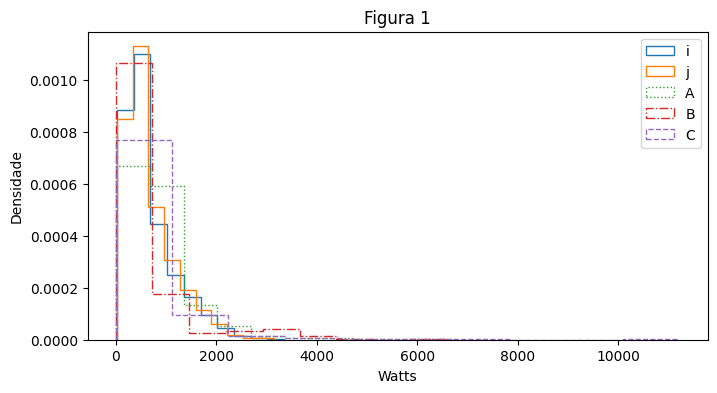

In [106]:
fig, ax = plt.subplots(figsize=(8, 4))
#ax.hist(C['Watts'], histtype='step', label='C')
ax.hist(i['Watts'], histtype='step', label='i', density=True)
ax.hist(j['Watts'], histtype='step', label='j', density=True)
ax.hist(A['Watts'], histtype='step', label='A', ls=':', density=True)
ax.hist(B['Watts'], histtype='step', label='B', ls='-.', density=True)
ax.hist(C['Watts'], histtype='step', label='C', ls='--', density=True)
plt.title("Figura 1")
plt.xlabel("Watts")
plt.ylabel("Densidade")
plt.legend();

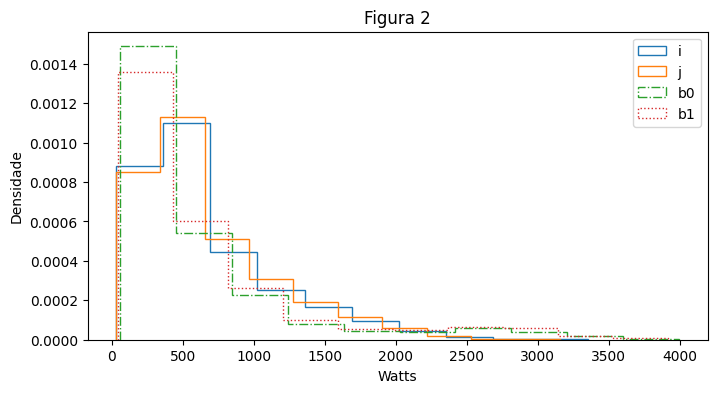

In [107]:
fig, ax = plt.subplots(figsize=(8, 4))
#ax.hist(C['Watts'], histtype='step', label='C')
ax.hist(i['Watts'], histtype='step', label='i', density=True)
ax.hist(j['Watts'], histtype='step', label='j', density=True)
ax.hist(b0['Watts'], histtype='step', label='b0', ls='-.', density=True)
ax.hist(b1['Watts'], histtype='step', label='b1', ls=':', density=True)
plt.title("Figura 2")
plt.xlabel("Watts")
plt.ylabel("Densidade")
plt.legend();

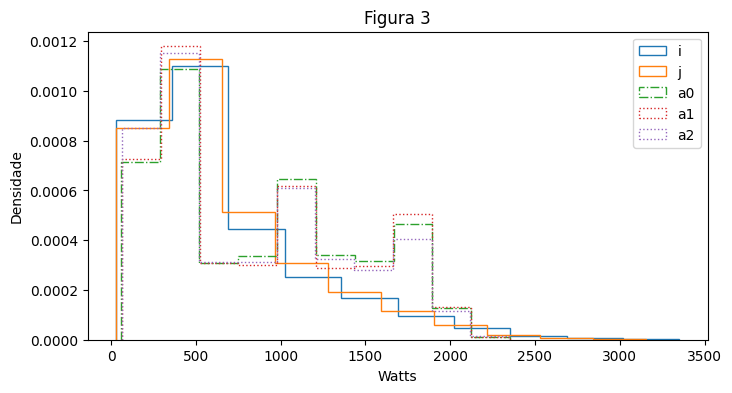

In [108]:
fig, ax = plt.subplots(figsize=(8, 4))
#ax.hist(C['Watts'], histtype='step', label='C')
ax.hist(i['Watts'], histtype='step', label='i', density=True)
ax.hist(j['Watts'], histtype='step', label='j', density=True)
ax.hist(a0['Watts'], histtype='step', label='a0', ls='-.', density=True)
ax.hist(a1['Watts'], histtype='step', label='a1', ls=':', density=True)
ax.hist(a2['Watts'], histtype='step', label='a2', ls=':', density=True)
plt.xlabel("Watts")
plt.ylabel("Densidade")
plt.title("Figura 3")
plt.legend();

In [15]:
from scipy.spatial.distance import euclidean
from scipy.special import rel_entr
from fastdtw import fastdtw

In [21]:
def probs(sample, bins):
    pesos = np.ones_like(sample)/len(sample)
    probs, b = np.histogram(sample, weights=pesos, bins=bins)
    probs[probs==0] = 0.0000001
    return probs

In [14]:
ds = ['i', 'j', 'a1']
for i, d in enumerate([i, j, a1]):
    dtw_distance, warp_path = fastdtw(C['Watts'], d['Watts'], dist=euclidean)
    print ("C - distance: ", dtw_distance, ds[i])

C - distance:  2446957.02462896 i
C - distance:  2536509.867332694 j
C - distance:  4069860.2056506383 a1


In [22]:
p_c = probs(C['Watts'].values, bins=100)
p_i = probs(i['Watts'].values, bins=100)
p_j = probs(j['Watts'].values, bins=100)
p_a1 = probs(a1['Watts'].values, bins=100)

In [109]:
def cdf(data, bins):
    count, bins_count = np.histogram(data, bins=bins)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    return cdf, pdf, bins_count

In [121]:
originais = ['A', 'B', 'C']
for k, o in enumerate([A, B, C]):
    p_o = probs(o['Watts'].values, bins=100)
    print (originais[k])
    for p in [p_i, p_j]:
        print (sum(rel_entr(p_o, p)))

A
0.262523263286217
0.31464321746256413
B
0.8259237254801141
0.8966312536719332
C
0.936667561139714
1.0130507143000054


In [111]:
from scipy.stats import ks_2samp


In [114]:
originais = ['A', 'B', 'C']
Cs = [i, j]
for k, o in enumerate([A, B, C]):
    c, _ , _ = cdf(o['Watts'].values, bins=100)
    print (originais[k])
    for f in Cs:
        cfake, _, _ = cdf(f['Watts'].values, bins=100)
        ks, _ = ks_2samp(c, cfake)
        print ("\t", ks)

A
	 0.21
	 0.23
B
	 0.24
	 0.27
C
	 0.38
	 0.4


In [30]:
p_a = probs(A['Watts'].values, bins=50)
p_b = probs(B['Watts'].values, bins=50)
p_c = probs(C['Watts'].values, bins=50)

In [115]:
n1 = np.random.randn(1000)
n2 = np.random.randn(1000)

In [122]:
cdf1 = cdf(n1, bins=100)
cdf2 = cdf(n2, bins=100)

probs1 = probs(n1, bins=100)
probs2 = probs(n2, bins=100)

In [120]:
ks_2samp(cdf1[0], cdf2[0])

KstestResult(statistic=0.09, pvalue=0.8154147124661313)

In [123]:
sum(rel_entr(probs1, probs2))

0.2303754656111757

In [94]:
print (i['Watts'].mean(), j['Watts'].mean())

655.2997277721037 659.6554032583841


In [95]:
print (a0['Watts'].mean(), a1['Watts'].mean())

871.402578112759 860.7404603585419
